Bitsandbytes: An excellent package that provides a lightweight wrapper around custom CUDA functions that make LLMs go faster — optimizers, matrix multiplication, and quantization. In this tutorial, we’ll be using this library to load our model as efficiently as possible.

transformers: A library by Hugging Face (🤗) that provides pre-trained models and training utilities for various natural language processing tasks.

peft: A library by Hugging Face (🤗) that enables parameter-efficient fine-tuning.


accelerate: Accelerate abstracts exactly and only the boilerplate code related to multi-GPUs/TPU/fp16 and leave the rest of your code unchanged.

datasets: Another library by Hugging Face (🤗) that provides easy access to a wide range of datasets.
einops: A library that simplifies tensor operations.

In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 938.2 kB/s eta 0:00:00


In [3]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [4]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: ··········
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [6]:
# https://huggingface.co/datasets/neil-code/dialogsum-test
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1999
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
})

In [7]:
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In the context of machine learning and neural networks, quantization refers to the process of reducing the precision of numerical values within the model. Typically, this involves reducing the number of bits used to represent each numerical value.

In the statement you provided, the model is being quantized to 4-bit format using the BitsAndBytesConfig. This means that instead of using the typical 32 or 64 bits to represent numerical values (such as weights and activations), only 4 bits will be used.

Quantization is often used to reduce the memory footprint and computational requirements of a neural network model. By using fewer bits to represent each numerical value, the model requires less memory and computational resources to store and process. However, this reduction in precision may lead to a decrease in model accuracy, as the model is less able to represent fine-grained numerical details.

Overall, quantization is a trade-off between model size, computational efficiency, and model accuracy. Different quantization strategies can be employed depending on the specific requirements and constraints of the application.







# Create bitsandbytes configuration

To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with BitesAndBytesConfig from the Transformers library. This will allow us to load our LLM in 4 bits. This way, we can divide the used memory by 4 and import the model on smaller devices.

In [8]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

In [9]:
model_name='microsoft/phi-2'
original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<a name='5'></a>
#### Tokenization
Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
print_gpu_utilization()

GPU memory occupied: 2318 MB.


In [11]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

def gen(model,p, maxlen=100, sample=True):
    toks = eval_tokenizer(p, return_tensors="pt")
    res = model.generate(**toks.to("cuda"), max_new_tokens=maxlen, do_sample=sample,num_return_sequences=1,temperature=0.1,num_beams=1,top_p=0.95,).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Test the Model with Zero Shot Inferencing

In [12]:
%%time
from transformers import set_seed
seed = 42
set_seed(seed)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = gen(original_model,formatted_prompt,100,)
#print(res[0])
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

The dataset cannot be directly employed for fine-tuning. It is essential to format the prompt in a way that the model can comprehend. Referring to the HuggingFace model documentation, it is evident that a prompt needs to be generated using dialogue and summary in the specified format below.

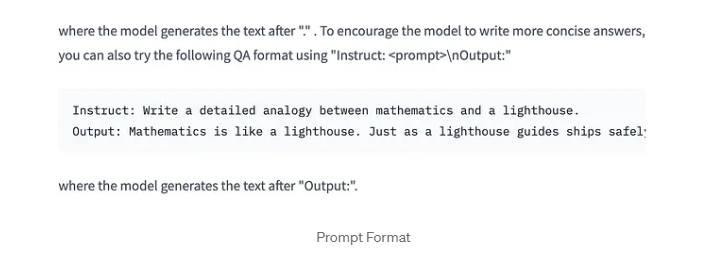

# Preprocesiing dataset

In [13]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

Our aim here is to generate input sequences with consistent lengths, which is beneficial for fine-tuning the language model by optimizing efficiency and minimizing computational overhead. It is essential to ensure that these sequences do not surpass the model’s maximum token limit.

In [14]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

In [15]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [16]:
print_gpu_utilization()

GPU memory occupied: 2596 MB.


In [19]:
# ## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

Found max lenth: 2048
2048
Preprocessing dataset...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1999 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/499 [00:00<?, ? examples/s]

In [20]:
print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(train_dataset)

Shapes of the datasets:
Training: (1999, 3)
Validation: (499, 3)
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1999
})


# Setup the PEFT/LoRA model for Fine-Tuning

Now, let's perform Parameter Efficient Fine-Tuning (PEFT) fine-tuning. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning. PEFT is a generic term that includes Low-Rank Adaptation (LoRA) and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, in essence, enables efficient model fine-tuning using fewer computational resources, often achievable with just a single GPU. Following LoRA fine-tuning for a specific task or use case, the outcome is an unchanged original LLM and the emergence of a considerably smaller "LoRA adapter," often representing a single-digit percentage of the original LLM size (in MBs rather than GBs).


During inference, the LoRA adapter must be combined with its original LLM. The advantage lies in the ability of many LoRA adapters to reuse the original LLM, thereby reducing overall memory requirements when handling multiple tasks and use cases.


Note the rank (r) hyper-parameter, which defines the rank/dimension of the adapter to be trained. r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.


alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

In [21]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 262364160
all model parameters: 1521392640
percentage of trainable model parameters: 17.24%


In [22]:
print(original_model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

**target_modules:** This is a list of strings (target_modules) specifying which modules within the model will be affected by the Lora mechanism. In this case, the Lora mechanism is applied to the modules responsible for linear projections (q_proj, k_proj, v_proj, dense). These are typically parts of the attention mechanism in transformer-based models.

**task_type:** This parameter (task_type) specifies the type of task the model is designed for. In this case, it's set to "CAUSAL_LM", indicating a causal language modeling task where the model predicts the next token in a sequence given the previous tokens.

In [23]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r = 32, #Rank
    lora_alpha = 32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

Once everything is set up and the base model is prepared, we can use the print_trainable_parameters() helper function to see how many trainable parameters are in the model.

In [24]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 20971520
all model parameters: 1542364160
percentage of trainable model parameters: 1.36%


In [25]:
# See how the model looks different now, with the LoRA adapters added:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4

#  Train PEFT Adapter

Define training arguments and create Trainer instance.

In [26]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

peft_training_args = TrainingArguments(
    output_dir = output_dir,
    warmup_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=400,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=25,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=25,
    evaluation_strategy="steps",
    eval_steps=25,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    overwrite_output_dir = 'True',
    group_by_length=True,
    push_to_hub=True
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [27]:
peft_training_args.device

device(type='cuda', index=0)

In [28]:
peft_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.656300,1.390015
50,1.188300,1.381830
75,1.443300,1.352416
100,1.203000,1.362708
125,1.439700,1.345105
150,1.139400,1.358548
175,1.403400,1.341247
200,1.144900,1.340585
225,1.444700,1.334206
250,1.227600,1.334461


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=400, training_loss=1.3200588178634645, metrics={'train_runtime': 3465.0709, 'train_samples_per_second': 0.462, 'train_steps_per_second': 0.115, 'total_flos': 7369972173619200.0, 'train_loss': 1.3200588178634645, 'epoch': 0.8})

In [29]:
peft_trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/JayShah07/final-checkpoint/commit/4f7b61a3c60b9494835665b648849a24bed52f8e', commit_message='Training completed!', commit_description='', oid='4f7b61a3c60b9494835665b648849a24bed52f8e', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
print_gpu_utilization()

GPU memory occupied: 10790 MB.


In [31]:
# Free memory for merging weights
del original_model
del peft_trainer
torch.cuda.empty_cache()

In [32]:
print_gpu_utilization()

GPU memory occupied: 3060 MB.


# Evaluate the Model Qualitatively (Human Evaluation)

In [33]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [35]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/peft-dialogue-summary-training/final-checkpoint/checkpoint-400",torch_dtype=torch.float16,is_trainable=False)

In [36]:
%%time
from transformers import set_seed
set_seed(seed)

index = 10
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

peft_model_res = gen(ft_model,prompt,100,)
peft_model_output = peft_model_res[0].split('Output:\n')[1]
#print(peft_model_output)
prefix, success, result = peft_model_output.partition('#End')

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'PEFT MODEL:\n{prefix}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

# Evaluate the Model Quantitatively (with ROUGE Metric)

In [37]:
original_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
import pandas as pd

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

    original_model_res = gen(original_model,prompt,100,)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]

    peft_model_res = gen(ft_model,prompt,100,)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    #print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('#End')


    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,"Person 1: Ms. Dawson, I need you to take a dic...",#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,"Person 1: Ms. Dawson, I need you to take a dic...",#Person1# tells Ms. Dawson to take a dictation...
2,Ms. Dawson takes a dictation for #Person1# abo...,"Person 1: Ms. Dawson, I need you to take a dic...",#Person1# tells Ms. Dawson to take a dictation...
3,#Person2# arrives late because of traffic jam....,Person1 and Person2 are discussing the traffic...,#Person2# got stuck in traffic again and #Pers...
4,#Person2# decides to follow #Person1#'s sugges...,Person2: I'm going to stop driving to work bec...,#Person2# got stuck in traffic again and #Pers...
5,#Person2# complains to #Person1# about the tra...,Person2: I'm going to stop driving to work bec...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Kate informed that Masha and Hero are getting ...,Kate tells #Person1# that Masha and Hero are g...
7,#Person1# tells Kate that Masha and Hero are g...,Kate informed that Masha and Hero are getting ...,Kate tells #Person1# that Masha and Hero are g...
8,#Person1# and Kate talk about the divorce betw...,Kate informed that Masha and Hero are getting ...,Kate tells #Person1# that Masha and Hero are g...
9,#Person1# and Brian are at the birthday party ...,"Person1 and Person2 are at a party, and Person...",Brian's birthday party is a success. Brian's f...


In [46]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [47]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=773ec5a9dd3cf0b54560ac3f43ef4e1e72fc49424610a2d7017de7c53100401d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [48]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.29032670752438156, 'rouge2': 0.09691933143634035, 'rougeL': 0.21914163474105702, 'rougeLsum': 0.22984462560120827}
PEFT MODEL:
{'rouge1': 0.4173105352861186, 'rouge2': 0.1410183788734835, 'rougeL': 0.29640986615771703, 'rougeLsum': 0.3086034743475262}


Rouge metrics are commonly used for evaluating the quality of automatic summarization and machine translation outputs by comparing them to reference summaries or translations.

Here's what each of the Rouge metrics stands for:

1. Rouge-1 (Rouge1): Measures the overlap of unigram (individual words) between the generated summary and the reference summary.


2. Rouge-2 (Rouge2): Measures the overlap of bigrams (pairs of consecutive words) between the generated summary and the reference summary.


3. Rouge-L (RougeL): Measures the longest common subsequence between the generated summary and the reference summary, considering the longest sequence of words that appears in both with the order preserved.


4. Rouge-Lsum (RougeLsum): Similar to Rouge-L, but it considers the longest common subsequence divided by the total number of words in the reference summary.

In [49]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 12.70%
rouge2: 4.41%
rougeL: 7.73%
rougeLsum: 7.88%


Fine-tuning is often an iterative process. Based on the validation and test sets results, we may need to make further adjustments to the model’s architecture, hyperparameters, or training data to improve its performance.